In [1]:
"""
Imports
"""
# !pip install numpy
# !pip install torch
# !pip install torchvision
# !pip install pandas
# !pip install opencv-python
# !pip install matplotlib
import os
import numpy as np
import time
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import csv
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset_age import FacesDataset
from data_augmentation import*

In [2]:
"""Creating the Neural Network Class"""
dropout = True;

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input: 48 x 48 x 1 = 2304
        ### Inputs to Conv2d: Incoming layers, outgoing layers, Frame size

        self.conv1 = nn.Conv2d(1, 2, 3)  #48 --> 46
        self.batchnorm1 = nn.BatchNorm2d(2)
        self.pool1 = nn.MaxPool2d(2, 2)  #46 --> 23
        self.conv2 = nn.Conv2d(2, 4, 3, stride=2)  #23 --> 11
        self.batchnorm2 = nn.BatchNorm2d(4)
        self.conv3 = nn.Conv2d(4, 8, 3, stride=2) #11 --> 5
        self.batchnorm3 = nn.BatchNorm2d(8)

        # Activation function to use
        self.activation = F.relu
    
        self.fc1 = nn.Linear(200, 50)
        self.batchnorm_fc1 = nn.BatchNorm1d(50)
        self.dropout1 = torch.nn.Dropout(p=0.5)    #p = probability of a neuron being dropped
        self.fc2 = nn.Linear(50, 10)
        self.batchnorm_fc2 = nn.BatchNorm1d(10)
        self.dropout2 = torch.nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.activation(self.batchnorm1(self.conv1(x)))
        x = self.pool1(x)
        x = self.activation(self.batchnorm2(self.conv2(x)))
        x = self.activation(self.batchnorm3(self.conv3(x)))
        x = x.view(-1, 200)
        x = self.activation(self.batchnorm_fc1(self.fc1(x)))
        if dropout:
            x = self.dropout1(x)
        x = self.activation(self.batchnorm_fc2(self.fc2(x)))
        if dropout:
            x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [3]:
"""Setting up neural network parameters, defining accuracy function"""
model = Net()
if torch.cuda.is_available():
    model.cuda()
# model.to(device)

target_epochs = 50
batch_size = 32

# learning_rate = 0.000000001  #11/12 2:07 PM (works, small range of 14-31)
# learning_rate = 0.0000000005   #11/12 2:15 PM (works, range of -7 to 50. seems to be making real (but inaccurate predictions))
learning_rate = 0.001
gamma = 0.95

# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

data_path = "../age_gender.csv"

dataset = FacesDataset(csv_file=data_path)
num_data_items = dataset.__len__()

train_set, test_set = torch.utils.data.random_split(dataset, [int(round(num_data_items*0.51)), int(round(num_data_items*0.49))])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_model = "model.pth"

if not os.path.exists(save_model):   #If there is not already a saved model file
    start_epoch = 0
    
    all_losses = []
    all_train_acc = []
    all_test_acc = []
else:
    checkpoint = torch.load(save_model, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    all_losses = checkpoint['all_losses']
    all_train_acc = checkpoint['all_train_acc']
    all_test_acc = checkpoint['all_test_acc']



def check_accuracy(loader, model):
    """
    Checks accuracy of the model by running it on the data in the dataloader passed as a parameter
    
    The closer the returned score is to 0, the better
    """
    num_correct_age = 0
    num_samples = loader.__len__()
    
    model.eval()  #Setting to eval mode will cause the model to ignore the dropout layers
    
    with torch.no_grad():  #speeds up process
        age_diffs_total = 0
        num_batches = 0
        for batch_idx, (x, y) in enumerate(loader):   #Looping through batches
            x = x.to(device=device)   #shape: (batch size, 48, 48)
            y = y.to(device=device)   #shape: (batch size, 3)
            
            #GETTING AND FORMATTING MODEL PREDICTIONS
            x = x.unsqueeze(1)   #Add a dimension to the tensor for number of channels (which is 1)
#             scores = model(x.float())   #Shape: (batch size, 3)
            scores = model(x.float()).reshape(-1)   #Shape: (batch size, 3)
#             print("scores: " + str(scores))
            
            #CALCULATING ACCURACY SCORE
            age_diffs = torch.abs(scores - y)
            age_diff_avg = torch.mean(age_diffs)
            
            age_diffs_total += age_diff_avg
            num_batches += 1
        
#         print(f'accuracy score (the closer to zero, the better): {total_accuracy}')
    return age_diffs_total/num_batches

In [4]:
"""Training"""
def train_batch(data, targets):
    #Get data to cuda if possible
        data = data.to(device=device)             #data is a torch tensor of [batch size] 48x48 images (shape=[batch size,48,48])
        data = data.unsqueeze(1)                  #Add a dimension to the tensor for number of channels (which is 1)
#         print("data.shape: " + str(data.shape))
        targets = targets.to(device=device)       #data is a torch tensor of (shape=[batch size,1])
#         print("targets.shape: " + str(targets.shape))
#         print("data[0,:,:].shape: " + str(np.array(data[0,:,:].shape)))
#         cv2.imwrite("test.png", np.array(data[0,:,:]))
        
        #Forward prop
        scores = model(data.float()).reshape(-1)
        
        #Calculating Accuracy Score
        #Old method (not using check_accuracy())
#         age_diffs = torch.abs(scores - targets)
#         train_acc = torch.mean(age_diffs).item() * 100        

        loss = criterion(scores, targets)
        
        #Backward prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  #gradient descent
        
        losses.append(loss.item())
        
        

for epoch in range(start_epoch+1, target_epochs+1):  #Looping through epochs
    losses = []
    
    model.train()
    
    for batch_idx, (data, targets) in enumerate(train_loader):   #Looping through batches
        train_batch(data, targets)   #Original Data
        data, targets = horiz_flip((data, targets), batch_size)
        train_batch(data, targets)   #Augmented Data: Horizontal Flip
         
    scheduler.step()
    
    #Calculating Accuray Score using check_accuracy()
    train_acc = check_accuracy(train_loader, model) * 100
    all_train_acc.append(train_acc.to("cpu").numpy())
    test_acc = check_accuracy(test_loader, model) * 100
    all_test_acc.append(test_acc.to("cpu").numpy())
    
    #Calculating Loss
    l = sum(losses)/len(losses)
    all_losses.append(l)
    
    print(f"Epoch: {epoch}, Loss: {l}, Train Acc: {train_acc}, Test Acc: {test_acc}")
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'all_losses': all_losses,
        'all_train_acc': all_train_acc,
        'all_test_acc': all_test_acc
    }, save_model)

Epoch: 6, Loss: 0.023131572037797282, Train Acc: 10.229072570800781, Test Acc: 10.474201202392578
Epoch: 7, Loss: 0.02204768105025684, Train Acc: 9.511990547180176, Test Acc: 9.815975189208984
Epoch: 8, Loss: 0.021012525483177454, Train Acc: 10.159575462341309, Test Acc: 10.422041893005371
Epoch: 9, Loss: 0.020487598994766515, Train Acc: 9.983158111572266, Test Acc: 10.256836891174316
Epoch: 10, Loss: 0.020105106719749827, Train Acc: 10.671960830688477, Test Acc: 10.841047286987305
Epoch: 11, Loss: 0.019597159728787287, Train Acc: 9.113856315612793, Test Acc: 9.53615951538086
Epoch: 12, Loss: 0.01973833987876162, Train Acc: 8.887048721313477, Test Acc: 9.350186347961426
Epoch: 13, Loss: 0.019416247577672557, Train Acc: 9.142993927001953, Test Acc: 9.6106538772583
Epoch: 14, Loss: 0.019098293036222458, Train Acc: 9.115715980529785, Test Acc: 9.521824836730957
Epoch: 15, Loss: 0.019068622907436397, Train Acc: 8.918054580688477, Test Acc: 9.362152099609375
Epoch: 16, Loss: 0.0189585320918

test trendline slope: -0.052182317278107675


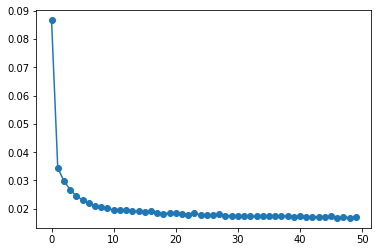

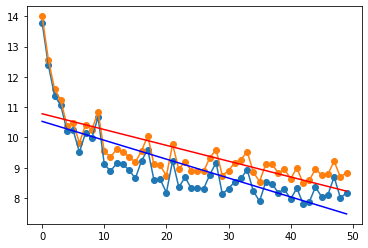

In [5]:
"""Plotting Results"""

def plot(loss, train_acc, test_acc):
    epochs_range = range(0, len(train_acc))
    
    #Creating Scatter Plot for Loss
    plt.figure()
    plt.scatter(range(0, len(all_losses)), loss)
    plt.plot(range(0, len(all_losses)), loss)
    
    #Creating Scatter Plot for Accuracy
    plt.figure()
    plt.scatter(epochs_range, train_acc)
    plt.scatter(epochs_range, test_acc)
    plt.plot(epochs_range, train_acc)
    plt.plot(epochs_range, test_acc)
    
    
    #Creating Linear Trendlines for Train Accuracy and Test Accuracy
    epochs_trend = np.linspace(epochs_range[0], epochs_range[-1], 100)
    
    train_coeff = np.polyfit(epochs_range, train_acc, 1)
    train_acc_trend = train_coeff[0]*epochs_trend + train_coeff[1]   #m*x + b
    plt.plot(epochs_trend, train_acc_trend,'b-')
    
    test_coeff = np.polyfit(epochs_range, test_acc, 1)
    test_acc_trend = test_coeff[0]*epochs_trend + test_coeff[1]   #m*x + b
    plt.plot(epochs_trend, test_acc_trend,'r-')
    print("test trendline slope: " + str(test_coeff[0]))
    
    
    #Saving plot to file
    now = datetime.now()
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d,%m,%Y_%H,%M,%S")
#     plt.savefig('../plots/loss_accuracy_' + dt_string + '.png')

plot(all_losses, all_train_acc, all_test_acc)

In [6]:
"""Getting prediction on single custom image"""
IMG_FILE = "../test_face2.jpg"

model.eval()
test_img = torch.Tensor(cv2.cvtColor(cv2.imread(IMG_FILE), cv2.COLOR_BGR2GRAY))   #getting image with shape (48, 48)
test_img = test_img.unsqueeze(0).unsqueeze(0)  #adding 2 dimensions to the image to get it to shape (1, 1, 48, 48). The 1st dimension represents batch of 1, the second represents color channels (I think)
outputs = model(test_img.to(device=device))
print(outputs)

tensor([[0.4644]], device='cuda:0', grad_fn=<AddmmBackward0>)


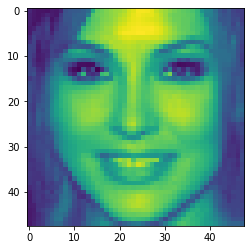

prediction: 26.563427.      Label: 22.000000


In [7]:
"""Getting prediction on a random image from the dataset (and retreiving label)"""
import random
item_tuple = dataset.__getitem__(random.randint(0, dataset.__len__()-1))
image = item_tuple[0]
label = item_tuple[1]*100

%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(image)
plt.show()

image = torch.Tensor(image)
image = image.unsqueeze(0).unsqueeze(0)  #adding 2 dimensions to the image to get it to shape (1, 1, 48, 48). The 1st dimension represents batch of 1, the second represents color channels (I think)
outputs = model(image.to(device=device)) * 100
print("prediction: %f.      Label: %f" % (outputs, label))

In [8]:
# """Getting prediction on a random image from the dataset (and retreiving label)"""
# import random
# item_tuple = dataset.__getitem__(random.randint(0, dataset.__len__()-1))
# image = item_tuple[0]
# label = item_tuple[1]

# %matplotlib inline
# from matplotlib import pyplot as plt
# plt.imshow(image)
# plt.show()

# __, img = torch.utils.data.random_split(dataset, [num_data_items-1, 1])
# loader = DataLoader(dataset=img, batch_size=1, shuffle=True)
# for batch_idx, (data, targets) in enumerate(loader):   #Looping through batches
#     #Get data to cuda if possible
#     data = data.to(device=device)             #data is a torch tensor of [batch size] 48x48 images (shape=[batch size,48,48])
#     data = data.unsqueeze(1)                  #Add a dimension to the tensor for number of channels (which is 1)

#     #Forward prop
#     scores = model(data.float()).reshape(-1)

#     print("prediction: %f.      Label: %d" % (scores.item(), int(label.item())))